In [353]:
import numpy as np
from utils import *
from scipy.linalg import expm

def pi_func(v):
	'''
	projection function
	'''
	v_proj=np.divide(v,v[2])
	return v_proj

def J_pi_func(v):
	'''
	Jacobian of projection function
	'''
	a=np.array([[1,0,-v[0]/v[2],0],
			  [0,1,-v[1]/v[2],0],
			  [0,0,0,0],
			  [0,0,-v[3]/v[2],1]])
	a=a/v[2]
	# J=a/v[2]
	return a


def hat_operator(v):
	'''
	Hat operator
	'''
	return np.array([[0,-v[2],v[1]],[v[2],0,-v[0]],[-v[1],v[0],0]])

def big_dot_opp(v):
	return np.block([[np.eye(3),-1*hat_operator(v)],[np.zeros((1,6))]])

# Stereo camera calibration matrix M

def visualize_trajectory_2d_traj(pose,path_name="Unknown",show_ori=False):
    fig,ax = plt.subplots(figsize=(5,5))
    n_pose = pose.shape[2]
    ax.plot(pose[0,3,:],pose[1,3,:],'r-',label=path_name)
#     ax.plot(landmark[0,:],landmark[1,:],'bo',markersize=1,label="landmark")
    ax.scatter(pose[0,3,0],pose[1,3,0],marker='s',label="start")
    ax.scatter(pose[0,3,-1],pose[1,3,-1],marker='o',label="end")
    if show_ori:
        select_ori_index = list(range(0,n_pose,max(int(n_pose/50), 1)))
        yaw_list = []
        for i in select_ori_index:
            _,_,yaw = mat2euler(pose[:3,:3,i])
        yaw_list.append(yaw)
        dx = np.cos(yaw_list)
        dy = np.sin(yaw_list)
        dx,dy = [dx,dy]/np.sqrt(dx**2+dy**2)
        ax.quiver(pose[0,3,select_ori_index],pose[1,3,select_ori_index],dx,dy,color="b",units="xy",width=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('equal')
    ax.grid(False)
    ax.legend()
    plt.show(block=True)
    return fig, ax



In [561]:
if __name__ == '__main__':
    filename = "./data/0034.npz"
    t,features,linear_velocity,rotational_velocity,K,b,cam_T_imu = load_data(filename)
    
    seen_ind=np.zeros((len(t.T), np.shape(features)[1]))[0]
    count=(np.zeros((np.shape(features)[1])))
#     for time in np.arange(0,len(t.T),1):
#         seen_index=np.array(np.where(np.sum(features[:,:,time],axis=0)!=-4 ))[0]
#         count[seen_index]+=1

#     features=features[:,np.where(count>30)[0],:]
#     print(features.shape)
    
    # Downsampling features
    # A=np.zeros((np.shape(features)[0],int(np.shape(features)[1]/10),np.shape(features)[2]))
    # for k in np.arange(0,np.shape(features)[1],10):
    # 	A[:,int(k/10),:]=features[:,k,:]
    # features=A
    
    features=features[:,::10,:]
    print(features.shape)
    
    o_T_r=np.array([[0,-1,0,0],[0,0,-1,0],[1,0,0,0],[0,0,0,1]])
    trajectory = np.zeros((4,4,np.size(t)))
    imu_mu_t_t = np.identity(4)					# mean
#     imu_mu =0.5* np.identity(4)
    imu_sigma_t_t = np.identity(6)				# covariance
    imu_sigma=np.identity(6)
    trajectory[:,:,0] = imu_mu_t_t
    Proj=np.block([np.identity(3),np.zeros((3,1))])
    M=np.block([[K[0:2,:], np.zeros((2,1))],[K[0:2,:], np.zeros((2,1))]])
    M[2,3] = -K[0,0]*b
    V=15
    motion_noise=0.0001
    landmark_mu_t = -1*np.ones((4,np.shape(features)[1]))	# mean	4*M
    landmark_sigma_t = np.identity(3*np.shape(features)[1])*V	# covariance	3M*3M
    I = np.vstack((np.identity(3),np.zeros((1,3))))
    I = np.kron(np.eye(np.shape(features)[1]),I)
    E=(np.eye(3*np.shape(features)[1]))
#     plt.plot(count)

(4, 482, 1224)


In [562]:
def feature_to_world(features, wTc, M, b):
    # covert pixel to world coordinates
    result = np.ones((4,np.shape(features)[1]))
    result[0,:] = (features[0,:]-M[0,2])*b/(features[0,:]-features[2,:])
    result[1,:] = (features[1,:]-M[1,2])*(-M[2,3])/(M[1,1]*(features[0,:]-features[2,:]))
    result[2,:] = -M[2,3]/(features[0,:]-features[2,:])
    result = np.dot(wTc,result)
    return result

In [563]:
# (a) IMU Localization via EKF Prediction
for time in np.arange(1,len(t.T),1):
    # H_t_big=np.zeros(( (4*np.shape(features)[1]),(3*np.shape(features)[1]) )) # 4*Nt x 3*Nt matrix
    #sigma_localize=np.zeros((len(imu_sigma_t_t)+len(landmark_sigma_t), len(imu_sigma_t_t)+len(landmark_sigma_t) ))
    # print(time-1)
    tau = t[0,time] - t[0,time-1]
    ut = np.vstack((linear_velocity[:,time].reshape(3,1),rotational_velocity[:,time].reshape(3,1)))
    ut_hat=np.hstack((np.vstack((hat_operator(rotational_velocity[:,time]),np.zeros(3))), np.hstack((linear_velocity[:,time],0)).reshape(4,1) ))
    ut_cap=np.vstack((np.hstack((hat_operator(rotational_velocity[:,time]),hat_operator(linear_velocity[:,time]))),np.hstack((np.zeros((3,3)), hat_operator(rotational_velocity[:,time]))) ))
    imu_mu_t_t=np.matmul(expm(-tau*ut_hat),imu_mu_t_t) # imu_mu_t_t is imu_mu_t+1_t same with imu_sigma_t_t
    # imu_sigma_t_t=expm(-tau*ut_cap)@imu_sigma_t_t@np.transpose(expm(-tau*ut_cap))+np.random.multivariate_normal(np.zeros(6),0.5*np.identity(6),6)
    imu_sigma_t_t= np.linalg.multi_dot([expm(-tau*ut_cap), imu_sigma_t_t ,np.transpose(expm(-tau*ut_cap))])+motion_noise*np.eye(6) #np.random.multivariate_normal(np.zeros(6),0.5*np.identity(6),6)

    trajectory[:,:,time] = np.linalg.inv(imu_mu_t_t)
    # (b) Landmark Mapping via EKF Update

    Cam_T_W=np.matmul(cam_T_imu,imu_mu_t_t)
    W_T_Cam = np.linalg.inv(Cam_T_W)
    ind=np.array(np.where(np.sum(features[:,:,time],axis=0)!=-4 ))[0]
    update_feature_ind=np.empty(0,np.int16)
    update_feature=np.empty((4,0))
    H_t_next=np.zeros((4*(len(ind)),6 ))
    print(time-1)
    #In[]
    if (len(ind.T)!=0):
        valid_features=features[:,ind,time]
        features_time=features[:,:,time]
#         d= valid_features=(features[0,ind,time]-valid_features=features[2,ind,time])/
#         x_by_z=(valid_features[0,:]-M[0,2])/M[0,0]
#         y_by_z=(valid_features[1,:]-M[1,2])/M[1,1]
#         one_by_z=(-valid_features[2,:]+M[2,2]+(M[2,0]*x_by_z))/M[2,3]
#         x=x_by_z/one_by_z
#         y=y_by_z/one_by_z
#         z=1/one_by_z
#         # P_optical=np.linalg.pinv(M)@features[:,:,time]
#         P_optical=np.vstack((x,y,z,np.ones(len(ind))))
#         # P_cam=np.matmul(np.linalg.inv(o_T_r),P_optical)
#         # Convert to world frame
#         P_world_coord= np.matmul(W_T_Cam,P_optical)
        P_world_coord=feature_to_world(valid_features,W_T_Cam,M,b)
    
        for j in range(len(ind)):
            curr_ind=ind[j]
            if (np.array_equal(landmark_mu_t[:,ind[j]], np.array([-1,-1,-1,-1]) )):
                landmark_mu_t[:,ind[j]]=P_world_coord[:,j]
                # print(P_world_coord[:,j])
            else:
                # get the index of landmarks whose mu and sigma is to be updated
                update_feature_ind=np.append(update_feature_ind,curr_ind) 
                update_feature=np.hstack((update_feature,P_world_coord[:,j].reshape(4,1)))
#             print(j)

        if(np.size(update_feature_ind)!=0):
            mu_t_bar=landmark_mu_t[:,update_feature_ind]
            z_t_bar=np.matmul(M,pi_func(np.dot (Cam_T_W,mu_t_bar))) 
            z_t=features_time[:,update_feature_ind]
            temp=np.matmul(Cam_T_W,mu_t_bar)
            H_t=np.zeros((4*(len(update_feature_ind)),3*(np.shape(features)[1]) ))
            # H_t=np.zeros((4*(len(update_feature_ind)),3*len(update_feature_ind) ))
            for i in range(len(update_feature_ind)):
                q=update_feature_ind[i]
                H_t[4*i:4*(i+1),3*q:3*(q+1)]=np.matmul(np.matmul(M,J_pi_func(temp[:,i])), np.matmul(Cam_T_W,np.transpose(Proj)))
                # H_t_big[4*i:4*(i+1),3*q:3*(q+1)]=H_t[4*i:4*(i+1),3*q:3*(q+1)]				
        

            K_t=np.linalg.multi_dot([landmark_sigma_t,
                                    np.transpose(H_t), 
                                    np.linalg.inv(np.linalg.multi_dot([H_t,landmark_sigma_t,np.transpose(H_t)])+(V*np.identity(4*np.size(update_feature_ind))))])	
            landmark_mu_t= ((landmark_mu_t.reshape(-1,1,order='F'))+ ( np.linalg.multi_dot([I,K_t,((z_t-z_t_bar).reshape(-1,1,order='F'))]) )).reshape(4,-1,order='F')
            landmark_sigma_t=np.dot((E-np.dot(K_t,H_t)),landmark_sigma_t)
        
                # (c) Visual-Inertial SLAM------------------------------------------------------------     
        
        for k in range(len(ind)):
            H_t_next[4*k:4*(k+1),0:6]=M@J_pi_func(Cam_T_W@landmark_mu_t[:,ind[k]])@cam_T_imu@big_dot_opp((imu_mu_t_t@landmark_mu_t[:,ind[k]]))
            # else:
            # 	H_t_next[4*j:4*(j+1),0:6]=np.zeros((4,6))
            # H_t_localize=np.hstack((H_t_next,H_t_big))

#         print(k)
        cam_landmark=np.matmul(M,pi_func(np.matmul (Cam_T_W,landmark_mu_t[:,ind])))
        Z_bar=cam_landmark #M@pi_func(cam_landmark)

        # sigma_localize[0:6,0:6]=imu_sigma_t_t
        sigma_localize=imu_sigma_t_t

        K_t_next=(sigma_localize@(H_t_next.T))@np.linalg.inv( (H_t_next@sigma_localize@H_t_next.T)+ (V*np.identity(4*len(ind)) ) )
        e=(K_t_next@((features[:,ind,time]-Z_bar).reshape(-1,1,order='F')))

        e_cap=np.hstack((np.vstack((hat_operator(e[3:6,0]),np.zeros(3))), np.hstack((e[0:3,0],0)).reshape(4,1) ))
        # e_cap=np.vstack((np.hstack((hat_operator(e[3:6,0]),hat_operator(e[0:3,0]))),np.hstack((np.zeros((3,3)), hat_operator(e[3:6,0]))) ))
        imu_mu_t_t_next=expm(e_cap)@imu_mu_t_t
        imu_mu_t_t=imu_mu_t_t_next

        sigma_localize= ((np.eye(len(sigma_localize))-(K_t_next@H_t_next))@sigma_localize)
        imu_sigma_t_t=sigma_localize

        
        
#         Cam_T_W_new=np.matmul(cam_T_imu,imu_mu_t_t)
#         if(np.size(update_feature_ind)!=0):
#             mu_t_bar=landmark_mu_t[:,update_feature_ind]
#             z_t_bar=np.matmul(M,pi_func(np.dot (Cam_T_W_new,mu_t_bar))) 
#             z_t=features_time[:,update_feature_ind]
#             temp=np.matmul(Cam_T_W_new,mu_t_bar)
#             H_t=np.zeros((4*(len(update_feature_ind)),3*(np.shape(features)[1]) ))
#             # H_t=np.zeros((4*(len(update_feature_ind)),3*len(update_feature_ind) ))
#             for i in range(len(update_feature_ind)):
#                 q=update_feature_ind[i]
#                 H_t[4*i:4*(i+1),3*q:3*(q+1)]=np.matmul(np.matmul(M,J_pi_func(temp[:,i])), np.matmul(Cam_T_W_new,np.transpose(Proj)))
#                 # H_t_big[4*i:4*(i+1),3*q:3*(q+1)]=H_t[4*i:4*(i+1),3*q:3*(q+1)]				
        

#             K_t=np.linalg.multi_dot([landmark_sigma_t,
#                                     np.transpose(H_t), 
#                                     np.linalg.inv(np.linalg.multi_dot([H_t,landmark_sigma_t,np.transpose(H_t)])+(100*np.identity(4*np.size(update_feature_ind))))])	
#             landmark_mu_t= ((landmark_mu_t.reshape(-1,1,order='F'))+ ( np.linalg.multi_dot([I,K_t,((z_t-z_t_bar).reshape(-1,1,order='F'))]) )).reshape(4,-1,order='F')
#             landmark_sigma_t=np.dot((E-np.dot(K_t,H_t)),landmark_sigma_t)
        
#         else:
            
        # imu_mu_t_t=imu_mu_t_t_next

            # sigma_localize= ((np.eye(len(sigma_localize))-(K_t_next@H_t_localize))@sigma_localize)
            # imu_sigma_t_t=sigma_localize[0:6,0:6]


    # imu_sigma=sigma_localize

    # else:
    # 	print('else statement')
    # 	imu_mu=imu_mu_t_t
    # 	imu_sigma=imu_sigma_t_t	

        # trajectory[:,:,time] = np.linalg.inv(imu_mu_t_t)
        # landmark_sigma_t_next=sigma_localize[6:,6:]

        # for f in range(len(update_feature_ind)):
        # 	q=update_feature_ind[f]
        # 	landmark_sigma_t[3*f:3*(f+1),3*q:3*(q+1)]=sigma_localize[((3*f)+6):(3*(f+1))+6,((3*q)+6):(3*(q+1))+6]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

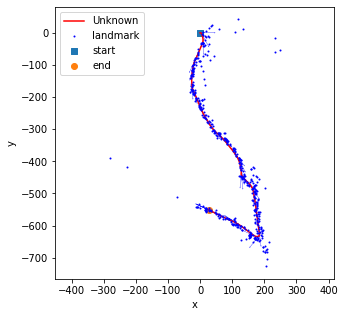

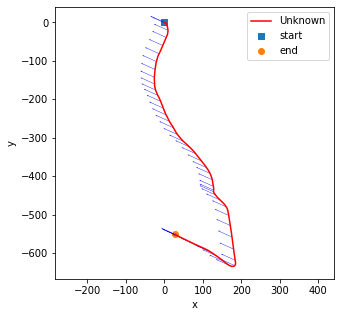

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x169e3995488>)

In [564]:
visualize_trajectory_2d(trajectory,landmark_mu_t,path_name="Unknown",show_ori=True)
visualize_trajectory_2d_traj(trajectory,path_name="Unknown",show_ori=True)

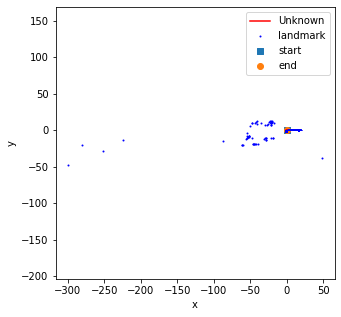

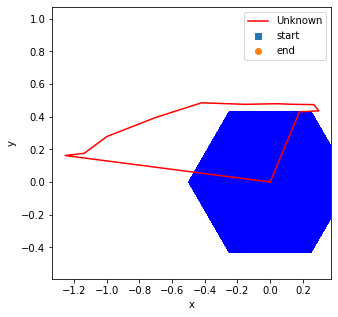

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x169c1576fc8>)

In [142]:
# You can use the function below to visualize the robot pose over time
#visualize_trajectory_2d(world_T_imu,show_ori=True)
# Data 0027.npy
visualize_trajectory_2d(trajectory,landmark_mu_t,path_name="Unknown",show_ori=True)
visualize_trajectory_2d_traj(trajectory,path_name="Unknown",show_ori=True)


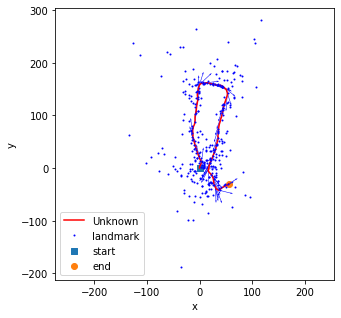

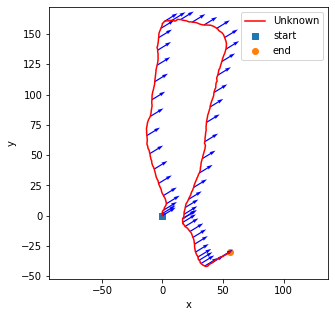

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x169c1ae3d08>)

In [130]:
# You can use the function below to visualize the robot pose over time
#visualize_trajectory_2d(world_T_imu,show_ori=True)
# Data 0022.npy
visualize_trajectory_2d(trajectory,landmark_mu_t,path_name="Unknown",show_ori=True)
visualize_trajectory_2d_traj(trajectory,path_name="Unknown",show_ori=True)


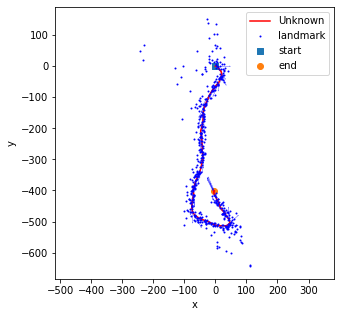

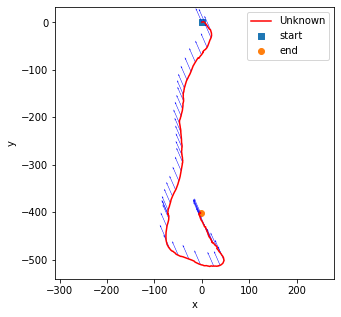

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x169c12f9c88>)

In [133]:
# You can use the function below to visualize the robot pose over time
#visualize_trajectory_2d(world_T_imu,show_ori=True)
# Data 0034.npy
visualize_trajectory_2d(trajectory,landmark_mu_t,path_name="Unknown",show_ori=True)
visualize_trajectory_2d_traj(trajectory,path_name="Unknown",show_ori=True)

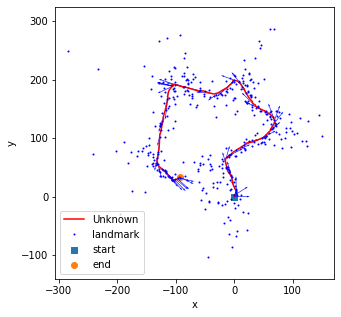

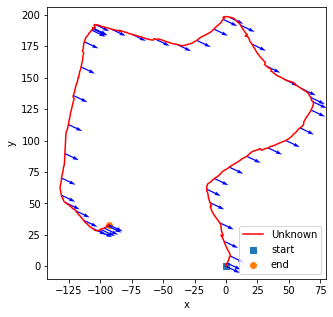

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x169c13f6208>)

In [136]:
# You can use the function below to visualize the robot pose over time
#visualize_trajectory_2d(world_T_imu,show_ori=True)
# Data 0027.npy
visualize_trajectory_2d(trajectory,landmark_mu_t,path_name="Unknown",show_ori=True)
visualize_trajectory_2d_traj(trajectory,path_name="Unknown",show_ori=True)

# HEre

In [298]:
# (a) IMU Localization via EKF Prediction
for time in np.arange(1,len(t.T),1):
    # H_t_big=np.zeros(( (4*np.shape(features)[1]),(3*np.shape(features)[1]) )) # 4*Nt x 3*Nt matrix
    #sigma_localize=np.zeros((len(imu_sigma_t_t)+len(landmark_sigma_t), len(imu_sigma_t_t)+len(landmark_sigma_t) ))
    # print(time-1)
    tau = t[0,time] - t[0,time-1]
    ut = np.vstack((linear_velocity[:,time].reshape(3,1),rotational_velocity[:,time].reshape(3,1)))
    ut_hat=np.hstack((np.vstack((hat_operator(rotational_velocity[:,time]),np.zeros(3))), np.hstack((linear_velocity[:,time],0)).reshape(4,1) ))
    ut_cap=np.vstack((np.hstack((hat_operator(rotational_velocity[:,time]),hat_operator(linear_velocity[:,time]))),np.hstack((np.zeros((3,3)), hat_operator(rotational_velocity[:,time]))) ))
    imu_mu_t_t=np.matmul(expm(-tau*ut_hat),imu_mu_t_t) # imu_mu_t_t is imu_mu_t+1_t same with imu_sigma_t_t
    # imu_sigma_t_t=expm(-tau*ut_cap)@imu_sigma_t_t@np.transpose(expm(-tau*ut_cap))+np.random.multivariate_normal(np.zeros(6),0.5*np.identity(6),6)
    imu_sigma_t_t= np.linalg.multi_dot([expm(-tau*ut_cap), imu_sigma_t_t ,np.transpose(expm(-tau*ut_cap))])+0.001*np.eye(6) #np.random.multivariate_normal(np.zeros(6),0.5*np.identity(6),6)

    trajectory[:,:,time] = np.linalg.inv(imu_mu_t_t)
    # (b) Landmark Mapping via EKF Update

    Cam_T_W=np.matmul(cam_T_imu,imu_mu_t_t)
    W_T_Cam = np.linalg.inv(Cam_T_W)
    ind=np.array(np.where(np.sum(features[:,:,time],axis=0)!=-4 ))[0]
    update_feature_ind=np.empty(0,np.int16)
    update_feature=np.empty((4,0))
#     H_t_next=np.zeros((4*(len(ind)),6 ))
    print(time-1)
    #In[]
    if (len(ind.T)!=0):
        valid_features=features[:,ind,time]
        features_time=features[:,:,time]
        x_by_z=(valid_features[0,:]-M[0,2])/M[0,0]
        y_by_z=(valid_features[1,:]-M[1,2])/M[1,1]
        one_by_z=(-valid_features[2,:]+M[2,2]+(M[2,0]*x_by_z))/M[2,3]
        x=x_by_z/one_by_z
        y=y_by_z/one_by_z
        z=1/one_by_z
        # P_optical=np.linalg.pinv(M)@features[:,:,time]
        P_optical=np.vstack((x,y,z,np.ones(len(ind))))
        # P_cam=np.matmul(np.linalg.inv(o_T_r),P_optical)
        # Convert to world frame
        P_world_coord= np.matmul(W_T_Cam,P_optical)

        for j in range(len(ind)):
            curr_ind=ind[j]
            if (np.array_equal(landmark_mu_t[:,ind[j]], np.array([-1,-1,-1,-1]) )):
                landmark_mu_t[:,ind[j]]=P_world_coord[:,j]
                # print(P_world_coord[:,j])
            else:
                # get the index of landmarks whose mu and sigma is to be updated
                update_feature_ind=np.append(update_feature_ind,curr_ind) 
                update_feature=np.hstack((update_feature,P_world_coord[:,j].reshape(4,1)))
#             print(j)

#         if(np.size(update_feature_ind)!=0):
        mu_t_bar=landmark_mu_t[:,ind]
        z_t_bar=np.matmul(M,pi_func(np.dot (Cam_T_W,mu_t_bar))) 
        z_t=features_time[:,ind]
        temp=np.matmul(Cam_T_W,mu_t_bar)
        H_t=np.zeros((4*(len(ind)),3*np.shape(features)[1]))
        # H_t=np.zeros((4*(len(update_feature_ind)),3*len(update_feature_ind) ))
        for i in range(len(update_feature_ind)):
            q=update_feature_ind[i]
            if(q in ind):
                H_t[4*i:4*(i+1),3*q:3*(q+1)]=np.matmul(np.matmul(M,J_pi_func(temp[:,i])), np.matmul(Cam_T_W,np.transpose(Proj)))
            else:
                H_t[4*i:4*(i+1),3*q:3*(q+1)]=np.zeros((4,3))
                
        K_t=landmark_sigma_t@H_t.T@ np.linalg.inv(H_t@landmark_sigma_t@H_t.T+(100*np.eye(4*len(ind))))
        landmark_mu_t= (((landmark_mu_t).reshape(-1,1,order='F'))-(I@K_t@((z_t-z_t_bar).reshape(-1,1,order='F')))).reshape(4,-1,order='F')
        landmark_sigma_t=np.dot((E-np.dot(K_t,H_t)),landmark_sigma_t)
        
        H_t_next=np.zeros((4*(len(ind)),6 ))
        for k in range(len(ind)):
            H_t_next[4*k:4*(k+1),0:6]=M@J_pi_func(Cam_T_W@landmark_mu_t[:,ind[k]])@cam_T_imu@big_dot_opp((imu_mu_t_t@landmark_mu_t[:,ind[k]]))

        cam_landmark=np.matmul(M,pi_func(np.matmul (Cam_T_W,landmark_mu_t[:,ind])))
        Z_bar=cam_landmark #M@pi_func(cam_landmark)

        # sigma_localize[0:6,0:6]=imu_sigma_t_t
        sigma_localize=imu_sigma_t_t
        
        B=(H_t_next@sigma_localize@H_t_next.T)
        A= B+(100*np.eye(4*len(ind)))
#         print(np.linalg.matrix_rank(A),len(A))
#         if(np.linalg.matrix_rank(A)<len(A)):
#             B=np.linalg.pinv(A)
#         else:
#             B=np.linalg.inv(A)
        
        K_t_next=(sigma_localize@(H_t_next.T))@((np.linalg.inv(A*np.max(A)))/np.max(A))
        e=(K_t_next@((features[:,ind,time]-Z_bar).reshape(-1,1,order='F')))

        e_cap=np.hstack((np.vstack((hat_operator(e[3:6,0]),np.zeros(3))), np.hstack((e[0:3,0],0)).reshape(4,1) ))
        # e_cap=np.vstack((np.hstack((hat_operator(e[3:6,0]),hat_operator(e[0:3,0]))),np.hstack((np.zeros((3,3)), hat_operator(e[3:6,0]))) ))
        imu_mu_t_t_next=expm(e_cap)@imu_mu_t_t
        imu_mu_t_t=imu_mu_t_t_next

        sigma_localize= ((np.eye(len(sigma_localize))-(K_t_next@H_t_next))@sigma_localize)
        imu_sigma_t_t=sigma_localize

        trajectory[:,:,time] = np.linalg.inv(imu_mu_t_t)
        

        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131


LinAlgError: Singular matrix

In [332]:
np.linalg.inv((np.around(A, decimals=0))/np.max(A))

LinAlgError: Singular matrix

In [248]:
((np.linalg.pinv( A/np.max(A) ))*np.max(A))

array([[ 3.04103059e+28, -1.70194889e+26,  3.83562058e+26,
        -1.70194883e+26,  4.46817925e+26, -9.23608093e+25,
         4.46391382e+26, -9.23608093e+25,  8.37065129e+27,
         7.51229656e+27,  8.45501207e+27,  7.51229656e+27,
         9.81064480e+28,  9.90202899e+28,  1.00115404e+29,
         9.90202899e+28,  1.27993478e+29,  1.27454784e+29,
         1.31101990e+29,  1.27454784e+29, -1.00915255e+28,
        -1.19016790e+28, -1.00671764e+28, -1.19016790e+28,
        -2.02640125e+32, -7.64679436e+31, -5.10164072e+33,
        -7.64679436e+31],
       [-1.31542259e+28,  7.36104219e+25, -1.65864915e+26,
         7.36104193e+25, -1.93238210e+26,  3.99122316e+25,
        -1.93053566e+26,  3.99122316e+25, -3.62044015e+27,
        -3.25334360e+27, -3.65695859e+27, -3.25334360e+27,
        -4.24313947e+28, -4.28812927e+28, -4.33009539e+28,
        -4.28812927e+28, -5.53579730e+28, -5.51951739e+28,
        -5.67034585e+28, -5.51951739e+28,  4.36437908e+27,
         5.15391188e+27,  4.35

In [222]:
np.max((H_t_next@sigma_localize@H_t_next.T))

1.3034021382473346e+34

In [217]:
(100*np.diag(np.arange(1,(4*len(ind)+1) )))

array([[ 100,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,  200,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,  300,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,  400,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,  500,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    

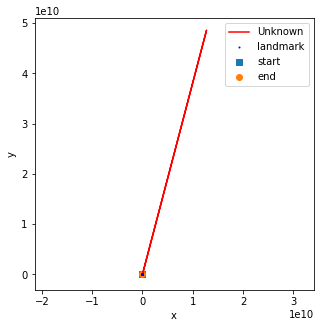

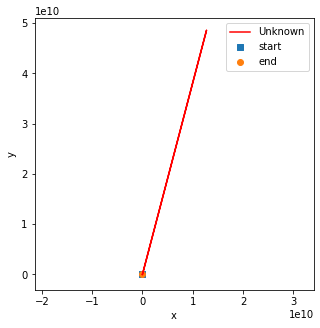

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x169c4a36288>)

In [295]:
visualize_trajectory_2d(trajectory,landmark_mu_t,path_name="Unknown",show_ori=True)
visualize_trajectory_2d_traj(trajectory,path_name="Unknown",show_ori=True)

In [279]:
np.linalg.inv(A+(90000*np.eye(4*len(ind))))

array([[ 1.03777617e-05,  3.81542725e-07, -7.70608284e-07, ...,
         1.09503897e-06,  2.76675506e-06,  1.09503897e-06],
       [ 3.85683316e-07,  4.68740519e-06,  6.16485355e-08, ...,
        -1.34844704e-06, -1.89680913e-06, -1.34844704e-06],
       [ 1.37618638e-06, -2.76566214e-07,  7.72622196e-06, ...,
        -2.37138156e-06, -5.35142318e-06, -2.37138156e-06],
       ...,
       [ 1.50861227e-06, -4.79130268e-07, -1.63603208e-06, ...,
         2.78167855e-06, -2.71877473e-06, -4.84771598e-06],
       [-1.42804250e-06, -4.22706225e-07,  1.49972496e-07, ...,
         2.06284757e-06,  1.31234487e-05,  2.06284757e-06],
       [ 1.50861227e-06, -4.79130268e-07, -1.63603208e-06, ...,
        -4.84771598e-06, -2.71877473e-06,  2.78167855e-06]])

array([[ 1.74869679e-20, -4.57554490e-21,  1.74869676e-20, ...,
        -4.57558322e-21,  1.74873491e-20, -4.57558322e-21],
       [-3.72262891e-21,  9.74037911e-22, -3.72262884e-21, ...,
         9.74046068e-22, -3.72271006e-21,  9.74046068e-22],
       [ 1.74869675e-20, -4.57554479e-21,  1.74869672e-20, ...,
        -4.57558311e-21,  1.74873487e-20, -4.57558311e-21],
       ...,
       [-3.72266157e-21,  9.74046372e-22, -3.72266150e-21, ...,
         9.74054529e-22, -3.72274272e-21,  9.74054529e-22],
       [ 1.74874194e-20, -4.57566261e-21,  1.74874190e-20, ...,
        -4.57570093e-21,  1.74878006e-20, -4.57570093e-21],
       [-3.72266157e-21,  9.74046372e-22, -3.72266150e-21, ...,
         9.74054529e-22, -3.72274272e-21,  9.74054529e-22]])

In [178]:
landmark_sigma_t=np.dot((E-np.dot(K_t,H_t)),landmark_sigma_t)

In [ ]:
        K_t=np.linalg.multi_dot([landmark_sigma_t,
                                np.transpose(H_t), 
                                np.linalg.inv(np.linalg.multi_dot([H_t,landmark_sigma_t,np.transpose(H_t)])+(V*np.identity(4*np.size(update_feature_ind))))])	
        landmark_mu_t= ((landmark_mu_t.reshape(-1,1,order='F'))+ ( np.linalg.multi_dot([I,K_t,((z_t-z_t_bar).reshape(-1,1,order='F'))]) )).reshape(4,-1,order='F')
        landmark_sigma_t=np.dot((E-np.dot(K_t,H_t)),landmark_sigma_t)

                # (c) Visual-Inertial SLAM------------------------------------------------------------     
        
        for k in range(len(ind)):
            H_t_next[4*k:4*(k+1),0:6]=M@J_pi_func(Cam_T_W@landmark_mu_t[:,ind[k]])@cam_T_imu@big_dot_opp((imu_mu_t_t@landmark_mu_t[:,ind[k]]))
            # else:
            # 	H_t_next[4*j:4*(j+1),0:6]=np.zeros((4,6))
            # H_t_localize=np.hstack((H_t_next,H_t_big))

#         print(k)
        cam_landmark=np.matmul(M,pi_func(np.matmul (Cam_T_W,landmark_mu_t[:,ind])))
        Z_bar=cam_landmark #M@pi_func(cam_landmark)

        # sigma_localize[0:6,0:6]=imu_sigma_t_t
        sigma_localize=imu_sigma_t_t

        K_t_next=(sigma_localize@(H_t_next.T))@np.linalg.inv( (H_t_next@sigma_localize@H_t_next.T)+ (V*np.identity(4*len(ind)) ) )
        e=(K_t_next@((features[:,ind,time]-Z_bar).reshape(-1,1,order='F')))

        e_cap=np.hstack((np.vstack((hat_operator(e[3:6,0]),np.zeros(3))), np.hstack((e[0:3,0],0)).reshape(4,1) ))
        # e_cap=np.vstack((np.hstack((hat_operator(e[3:6,0]),hat_operator(e[0:3,0]))),np.hstack((np.zeros((3,3)), hat_operator(e[3:6,0]))) ))
        imu_mu_t_t_next=expm(e_cap)@imu_mu_t_t
        imu_mu_t_t=imu_mu_t_t_next

        sigma_localize= ((np.eye(len(sigma_localize))-(K_t_next@H_t_next))@sigma_localize)
        imu_sigma_t_t=sigma_localize

        trajectory[:,:,time] = np.linalg.inv(imu_mu_t_t)
        
#         else:
            
        # imu_mu_t_t=imu_mu_t_t_next

            # sigma_localize= ((np.eye(len(sigma_localize))-(K_t_next@H_t_localize))@sigma_localize)
            # imu_sigma_t_t=sigma_localize[0:6,0:6]


    # imu_sigma=sigma_localize

    # else:
    # 	print('else statement')
    # 	imu_mu=imu_mu_t_t
    # 	imu_sigma=imu_sigma_t_t	

        # trajectory[:,:,time] = np.linalg.inv(imu_mu_t_t)
        # landmark_sigma_t_next=sigma_localize[6:,6:]

        # for f in range(len(update_feature_ind)):
        # 	q=update_feature_ind[f]
        # 	landmark_sigma_t[3*f:3*(f+1),3*q:3*(q+1)]=sigma_localize[((3*f)+6):(3*(f+1))+6,((3*q)+6):(3*(q+1))+6]